---
title: "Verificare il potenziale fotovoltaico di un tetto"
description: "Usando un software GIS è possibile stimare se un tetto è o meno idoneo per un impianto fotovoltaico. E' possibile fare la stessa cosa in Python? Te lo dico qui!"
date: "2022 05 22"
categories: [line]
image: "images/logo.jpg"
format:
    html:
        toc: true
        code-fold: true
execute:
  enabled: false
share:
  description: "Usando un software GIS è possibile stimare se un tetto è o meno idoneo per un impianto fotovoltaico. E' possibile fare la stessa cosa in Python? Te lo dico qui!"
  twitter: true
  facebook: true
  reddit: true
  stumble: true
  tumblr: true
  linkedin: true
  email: true
---

Un po' di tempo fa ho effettuato un'analisi finalizzata a stimare il [potenziale fotovoltaico](https://massimilianomoraca.it/blog/gis/fotovoltaico-e-gis-come-individuare-lutilizzabilita-di-un-tetto/) di un tetto usando QGIS. Con questo articolo voglio ripercorrere lo stesso flusso di lavoro usando però Python!

## Prima di iniziare


### Librerie
Per raggiungere l'obiettivo userò le librerie che seguono:

In [1]:
import pathlib
import geopandas as gpd
import rioxarray as rxr
import contextily as cx
import matplotlib.pyplot as plt
from xrspatial.aspect import aspect
from xrspatial.slope import slope

### Fonti dati

In [2]:
sample_data = pathlib.Path.cwd().parent.joinpath('sample_data/photovoltaic_potential_analysis')
dsm = sample_data.joinpath('dsm.tif')
buildings = sample_data.joinpath('buildings_footprint.shp')

# 1. Lettura dei dati

In [3]:
raster = rxr.open_rasterio(dsm, masked=True).squeeze()
raster

<xarray.DataArray (y: 500, x: 500)>
[250000 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 4.445e+05 4.445e+05 4.445e+05 ... 4.45e+05 4.45e+05
  * y            (y) float64 4.529e+06 4.529e+06 ... 4.529e+06 4.529e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [4]:
vector = gpd.read_file(buildings)
vector

,id,layer,tipoedific,uso,sup_m2,altezza,altez_dsm,geometry
0,0,0201N-Edificio Generico Nuovo,Edificio generico,Abitazione,54,4.67,36.77,"POLYGON ((444654.507 4529354.495, 444651.839 4..."
1,1,0201N-Edificio Generico Nuovo,Edificio generico,Abitazione,49,7.60,40.79,"POLYGON ((444639.838 4529162.951, 444638.794 4..."
2,2,0208N-Baracca Nuovo,Baracca,Altro,23,3.30,38.11,"POLYGON ((444726.330 4529069.704, 444730.929 4..."
3,3,0208I-Baracca Invariato,Baracca,Altro,22,3.19,37.95,"POLYGON ((444523.992 4529241.197, 444523.992 4..."
4,4,0208I-Baracca Invariato,Baracca,Altro,55,3.96,38.68,"POLYGON ((444518.076 4529233.077, 444518.192 4..."
...,...,...,...,...,...,...,...,...
312,312,0201I-Edificio Generico Invariato,Edificio generico,Abitazione,187,10.57,42.86,"POLYGON ((444676.418 4529355.727, 444676.008 4..."
313,313,0201M-Edificio Generico Modificato,Edificio generico,Abitazione,323,7.41,42.35,"POLYGON ((444545.683 4529221.436, 444524.605 4..."
314,314,0201I-Edificio Generico Invariato,Edificio generico,Abitazione,370,2.88,35.15,"POLYGON ((444723.780 4529165.567, 444719.890 4..."
315,315,0201M-Edificio Generico Modificato,Edificio generico,Abitazione,2389,11.78,45.07,"POLYGON ((444848.335 4529111.537, 444850.324 4..."


## 1.1 Visualizzazione dei dati grezzi

Text(0.5, 0, 'X coordinates (meters)')

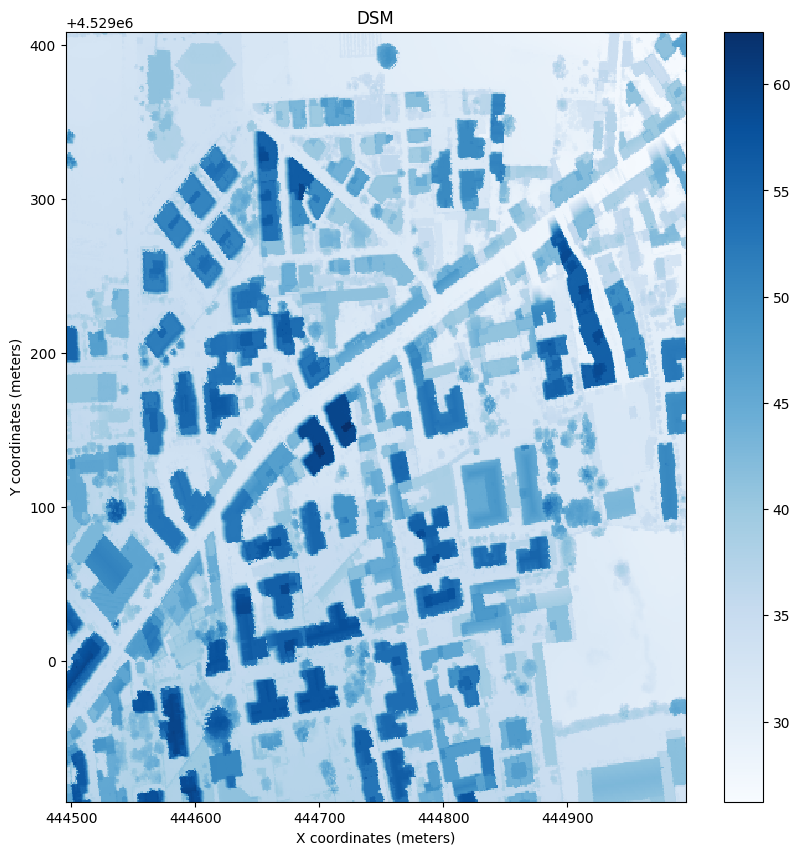

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
raster.plot.imshow(
    cmap='Blues',
)
plt.title("DSM")
plt.ylabel("Y coordinates (meters)")
plt.xlabel("X coordinates (meters)")

Text(0.5, 1.0, 'Area of Interest')

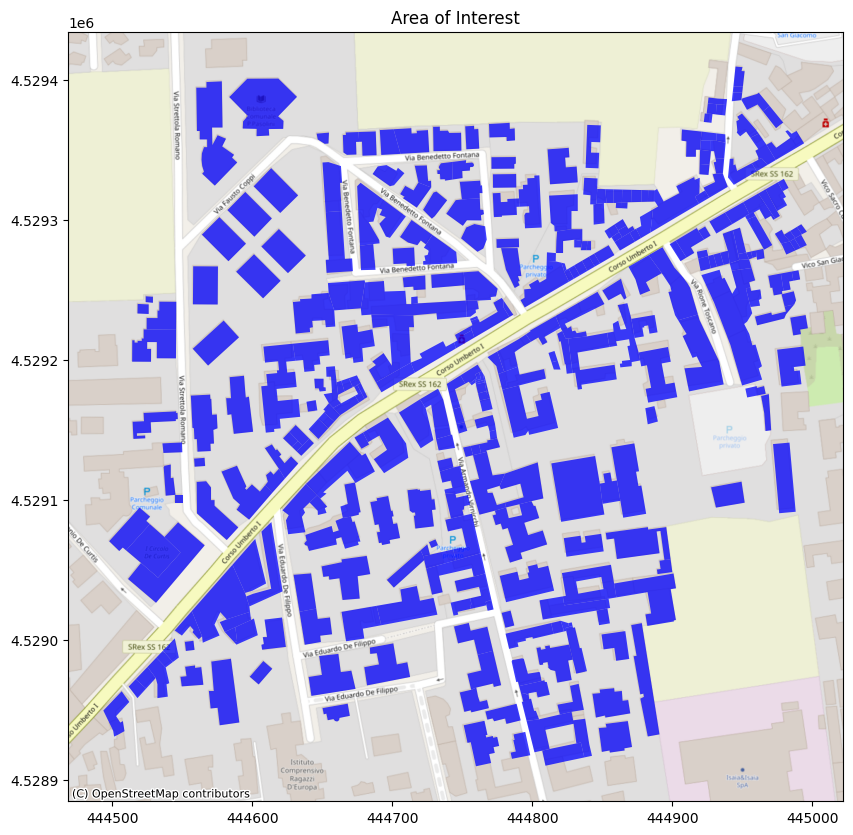

In [6]:
aoi = vector.plot(alpha=0.75, color="blue", figsize=(10, 10))
cx.add_basemap(aoi, crs=vector.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
aoi.set_title("Area of Interest")

# 2. Analisi dell'inclinazione dei tetti

Come primo passo in questa analisi estrarrò dal DSM i soli edifici.

Text(0.5, 0, 'X coordinates (meters)')

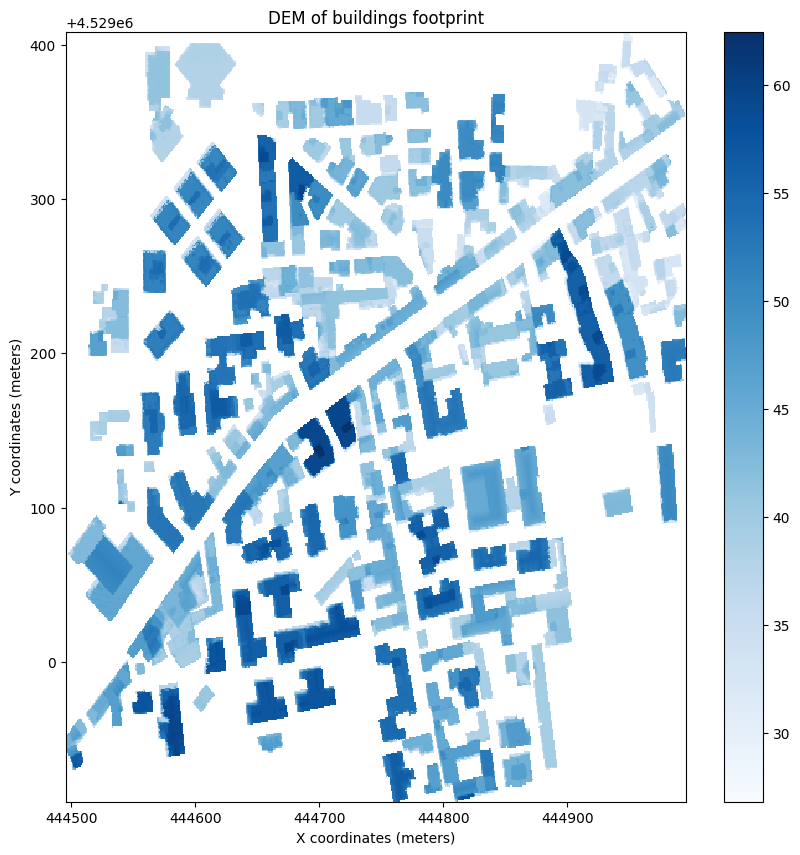

In [7]:
raster_clipped = raster.rio.clip(
    geometries=vector.geometry, crs=raster.rio.crs, all_touched=True, drop=True
).squeeze()

fig, ax = plt.subplots(figsize=(10, 10))

raster_clipped.plot.imshow(
    cmap='Blues',
)
plt.title("DEM of buildings footprint")
plt.ylabel("Y coordinates (meters)")
plt.xlabel("X coordinates (meters)")

A questo punto posso concentrarmi solo sui tetti calcolando la loro pendenza.

Text(0.5, 0, 'X coordinates (meters)')

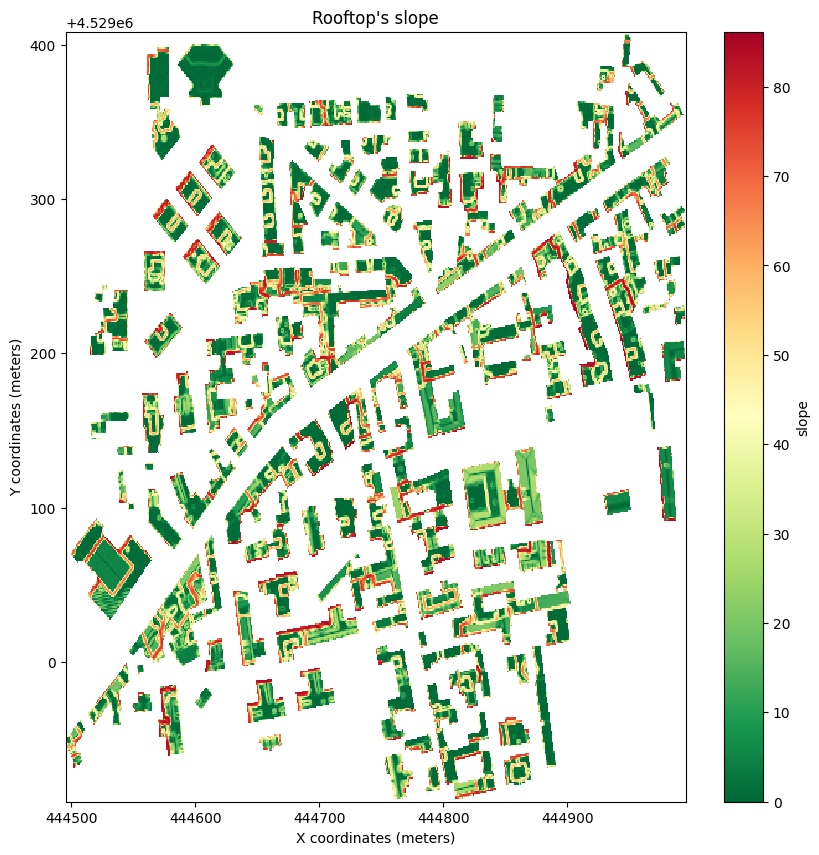

In [8]:
rooftop_slope = slope(raster_clipped)

fig, ax = plt.subplots(figsize=(10, 10))
colormap = plt.cm.get_cmap('RdYlGn')

rooftop_slope.plot.imshow(
    cmap=colormap.reversed(),
)
plt.title("Rooftop's slope")
plt.ylabel("Y coordinates (meters)")
plt.xlabel("X coordinates (meters)")

Le pendenze fanno riferimento al piano cartografico. Quindi 0° fa riferimento ad un tetto piano, con 85.8° di pendenza abbiamo un tetto quasi verticale e quindi ortogonale al piano cartografico.

La resa di un pannello fotovoltaico varia in base all'inclinazione rispetto ai raggi solari. Alle latitudini italiane la resa ottimale in fase di produzione di energia si ha quando i pannelli sono installati con una pendenza che varia tra i 30° ed i 40°. La pendenza ottimale è direttamente proporzionale alla [latitudine](https://it.wikipedia.org/wiki/Latitudine); più ci allontaniamo dall'equatore, più essa aumenta. Quindi nel sud Italia la pendenza ottimale si aggira intorno ai 30° mentre nel nord è intorno ai 40°. Non mi interessa entrare troppo nel dettaglio tecnico legato all'installazione di un impianto fotovoltaico ma dare una stima, una indicazione di produzione energetica, ma il passaggio sull'inclinazione è importante perchè con queste informazioni andrò ad effettuare le analisi successive suddividendo le pendenze dei tetti in tre classi:
- 0 - 3°
- 3° - 40°
- 40° - 90°

Questa suddivisione mi consentirà di individuare sia i tetti piani(quelli che rientrano nella prima classe) che i tetti con la giusta inclinazione per una installazione in pendenza ottimale dell'impianto, consentendomi di escludere quelli con pendenze non ottimali(terza ed ultima classe).

Qui magari, con questa esclusione, storce il naso un installatore di impianti fotovoltaici perchè ci sono soluzioni tecniche che consentono di ovviare il problema della pendenza eccessiva del tetto. Conosco questi aspetti ma a me interessa dare una visione di metodologia di analisi con questo articolo.

## 2.1 Tetti piani

Text(0.5, 0, 'X coordinates (meters)')

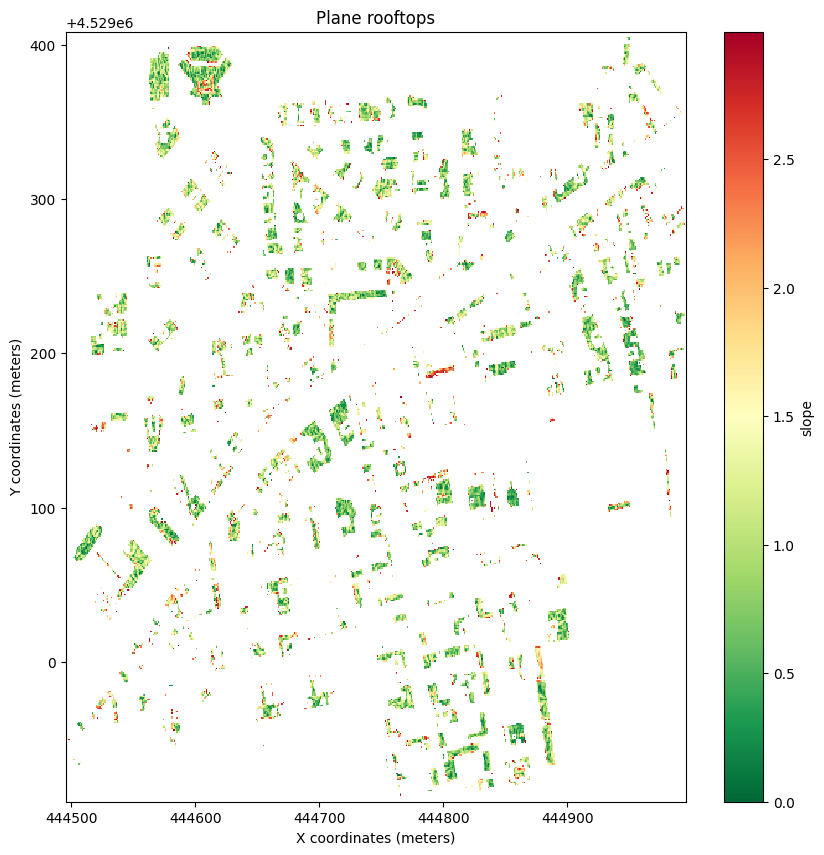

In [9]:
plane_rooftop = rooftop_slope.where(rooftop_slope <= 3)

fig, ax = plt.subplots(figsize=(10, 10))
colormap = plt.cm.get_cmap('RdYlGn')

plane_rooftop.plot.imshow(
    cmap=colormap.reversed(),
)
plt.title("Plane rooftops")
plt.ylabel("Y coordinates (meters)")
plt.xlabel("X coordinates (meters)")

## 2.2 Tetti con inclinazione ottimale

Text(0.5, 0, 'X coordinates (meters)')

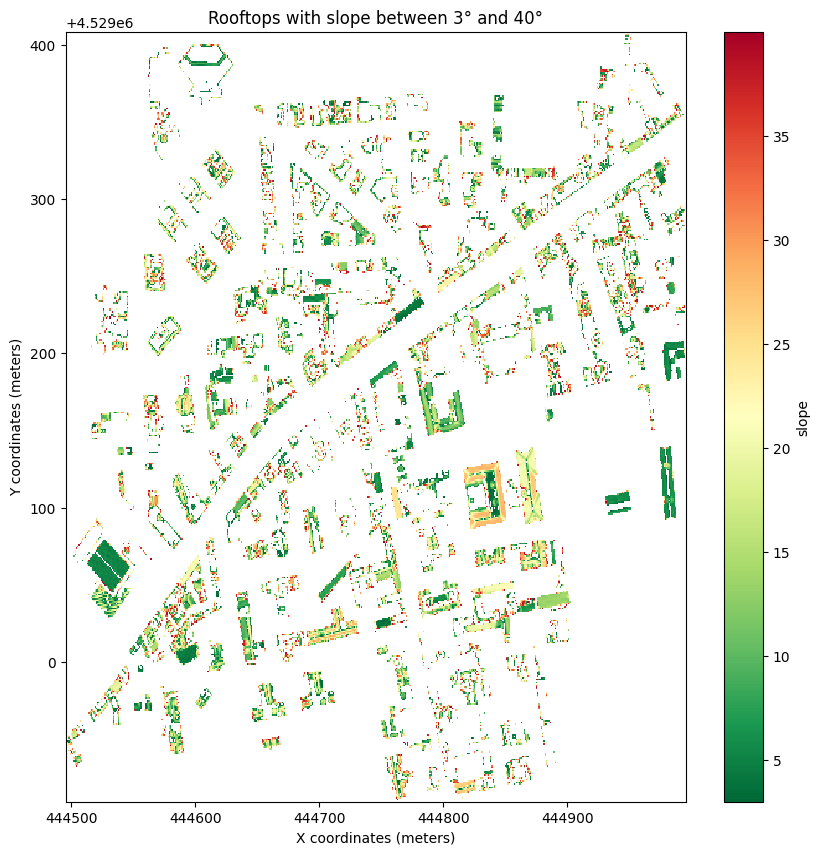

In [10]:
optimum_rooftop_inclination = rooftop_slope.where((rooftop_slope > 3) & (rooftop_slope <= 40))

fig, ax = plt.subplots(figsize=(10, 10))
colormap = plt.cm.get_cmap('RdYlGn')

optimum_rooftop_inclination.plot.imshow(
    cmap=colormap.reversed(),
)
plt.title("Rooftops with slope between 3° and 40°")
plt.ylabel("Y coordinates (meters)")
plt.xlabel("X coordinates (meters)")

# 3. Analisi dell'orientamento dei tetti

Individuate le pendenze del tetto, passiamo a considerare l'aspetto relativo all'esposizione, o orientamento, del tetto.

Per il discorso lagato alla resa migliore in fase di produzione di energia, anche l'orientamento del tetto è un fattore chiave. Per un tetto piano è insignificante parlare di esposizione, concetto che diventa fondamentale per un tetto inclinato. Anche qui ci sono soluzioni tecniche che possono risolvere problemi di esposizione ma, come scritto poco sopra, non è questo il luogo per approfondire questi aspetti.

Text(0.5, 0, 'X coordinates (meters)')

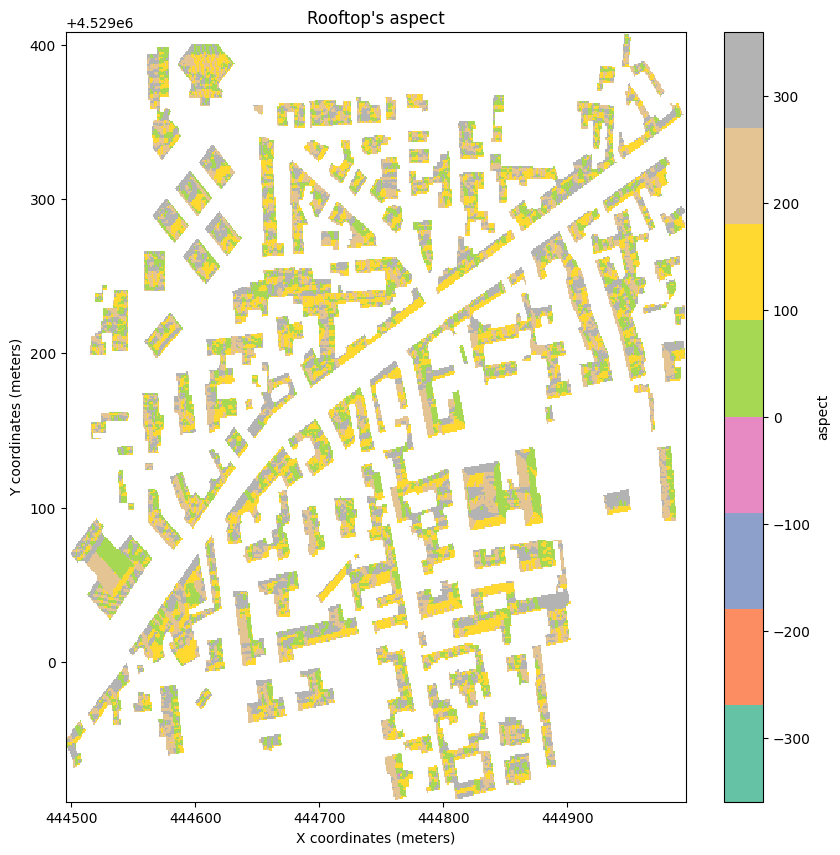

In [11]:
rooftop_aspect = aspect(raster_clipped)

fig, ax = plt.subplots(figsize=(10, 10))

rooftop_aspect.plot.imshow(
    cmap='Set2',
)
plt.title("Rooftop's aspect")
plt.ylabel("Y coordinates (meters)")
plt.xlabel("X coordinates (meters)")

L'esposizione ottimale è il SUD(*tra 135° e 225°*), quella sicuramente da scartare è il NORD(*tra 0° e 45°, tra 315° e 360°*).
![Rosa dei venti](https://as1.ftcdn.net/v2/jpg/01/74/27/88/500_F_174278831_b9BzZLu9tZNFKyT72vxL4TQuuEXmc7e4.jpg "Rosa dei venti | Immagine concessa con Licenza Standard Adobe")

Io andrò ad estrarre solo i tetti con esposizione da **EST** a **SUD-EST**, da **SUD-EST** a **SUD-OVEST** ad **OVEST**, quindi:
- 90° - 135°
- 135° - 225°
- 225° - 270°

## 3.1 Tetti esposti a SUD

Text(0.5, 0, 'X coordinates (meters)')

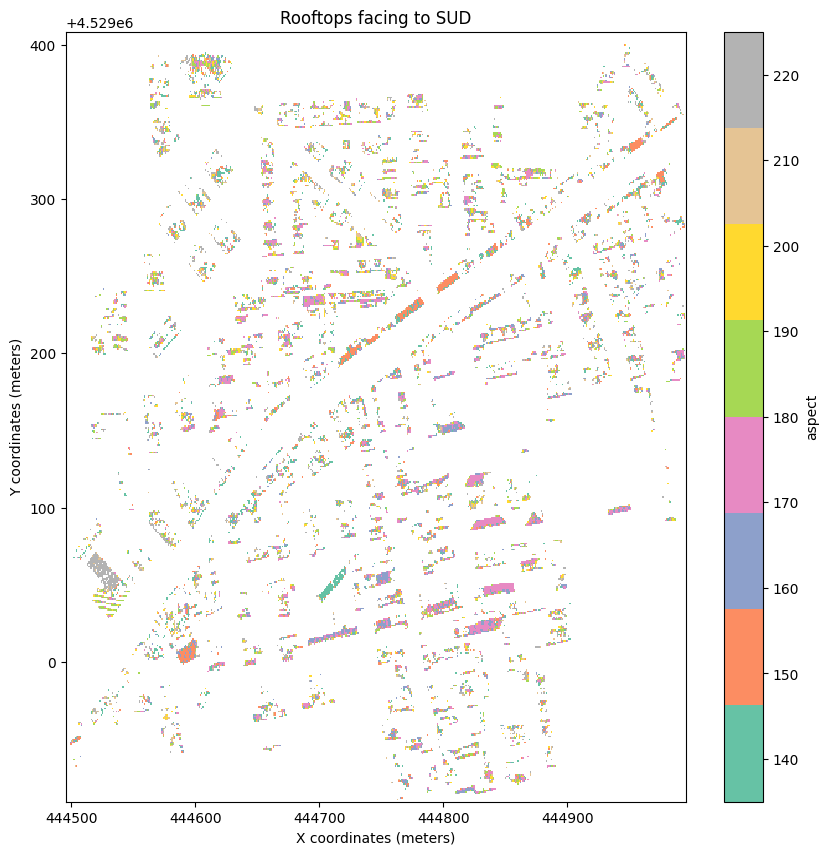

In [12]:
sud_rooftop_aspect = rooftop_aspect.where((rooftop_aspect >= 135) & (rooftop_aspect <= 225))

fig, ax = plt.subplots(figsize=(10, 10))

sud_rooftop_aspect.plot.imshow(
    cmap='Set2',
)
plt.title("Rooftops facing to SUD")
plt.ylabel("Y coordinates (meters)")
plt.xlabel("X coordinates (meters)")

## 3.2 Tetti esposti ad EST

Text(0.5, 0, 'X coordinates (meters)')

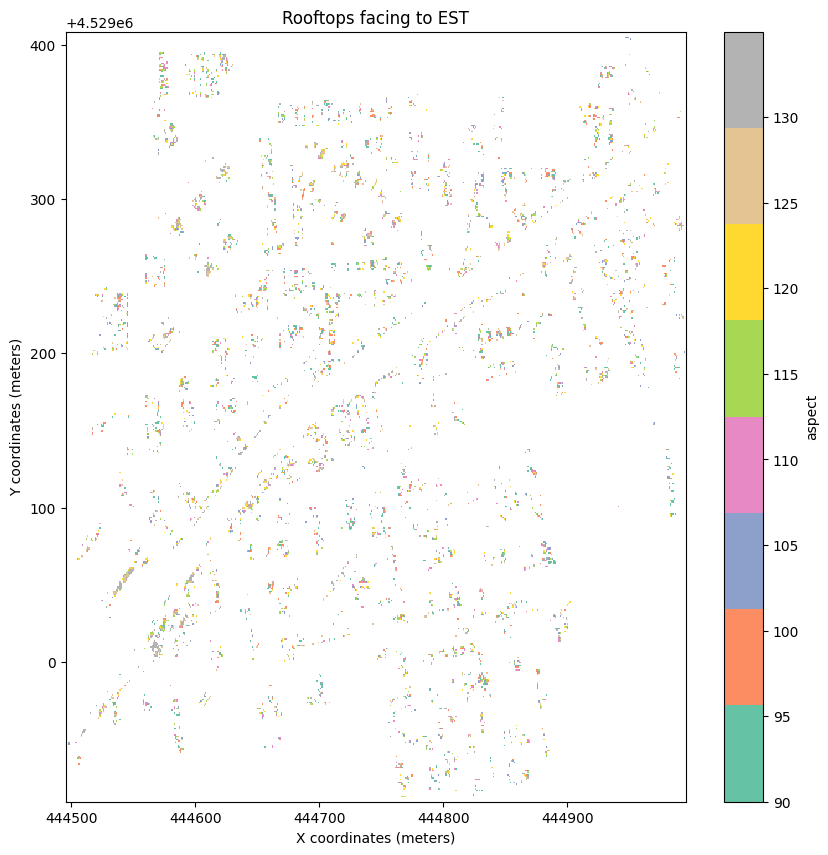

In [13]:
est_rooftop_aspect = rooftop_aspect.where((rooftop_aspect >= 90) & (rooftop_aspect < 135))

fig, ax = plt.subplots(figsize=(10, 10))

est_rooftop_aspect.plot.imshow(
    cmap='Set2',
)
plt.title("Rooftops facing to EST")
plt.ylabel("Y coordinates (meters)")
plt.xlabel("X coordinates (meters)")

## 3.2 Tetti esposti ad OVEST

Text(0.5, 0, 'X coordinates (meters)')

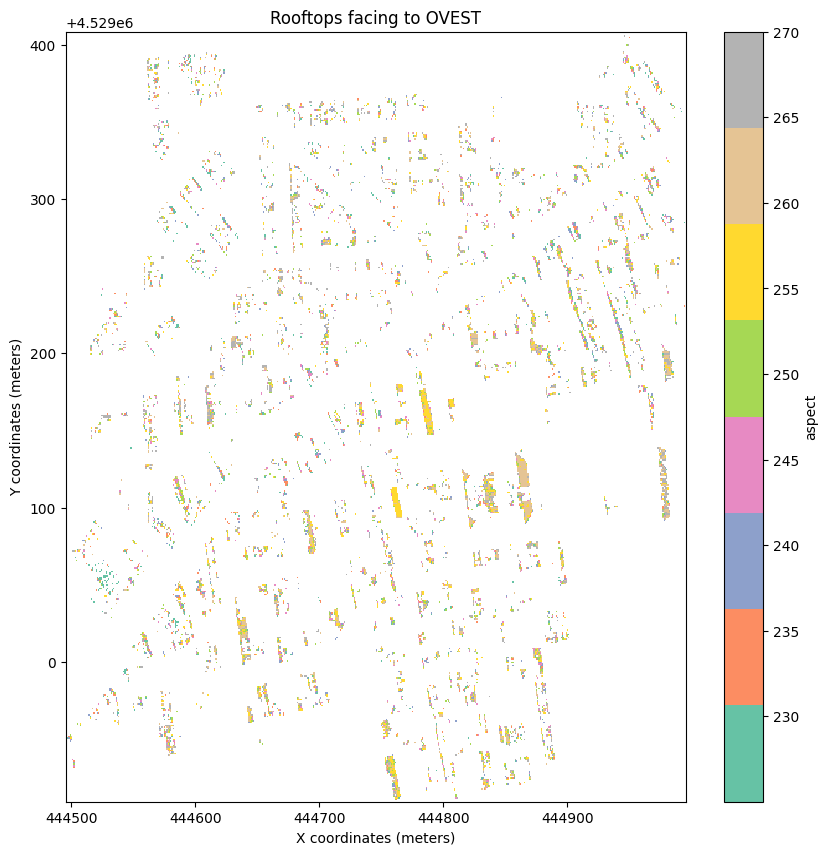

In [14]:
ovest_rooftop_aspect = rooftop_aspect.where((rooftop_aspect > 225) & (rooftop_aspect <= 270))

fig, ax = plt.subplots(figsize=(10, 10))

ovest_rooftop_aspect.plot.imshow(
    cmap='Set2',
)
plt.title("Rooftops facing to OVEST")
plt.ylabel("Y coordinates (meters)")
plt.xlabel("X coordinates (meters)")

# 4. Produzione energetica stimata

Ora che ho una chiara idea delle aree di intervento procederò a stimare la produzione energetica dei tetti presenti nell'area in esame. Prima però è necessario affinare ulteriormente i dati.

## 4.1 Put them all togheter

Text(0.5, 1.0, "Rooftop's slope")

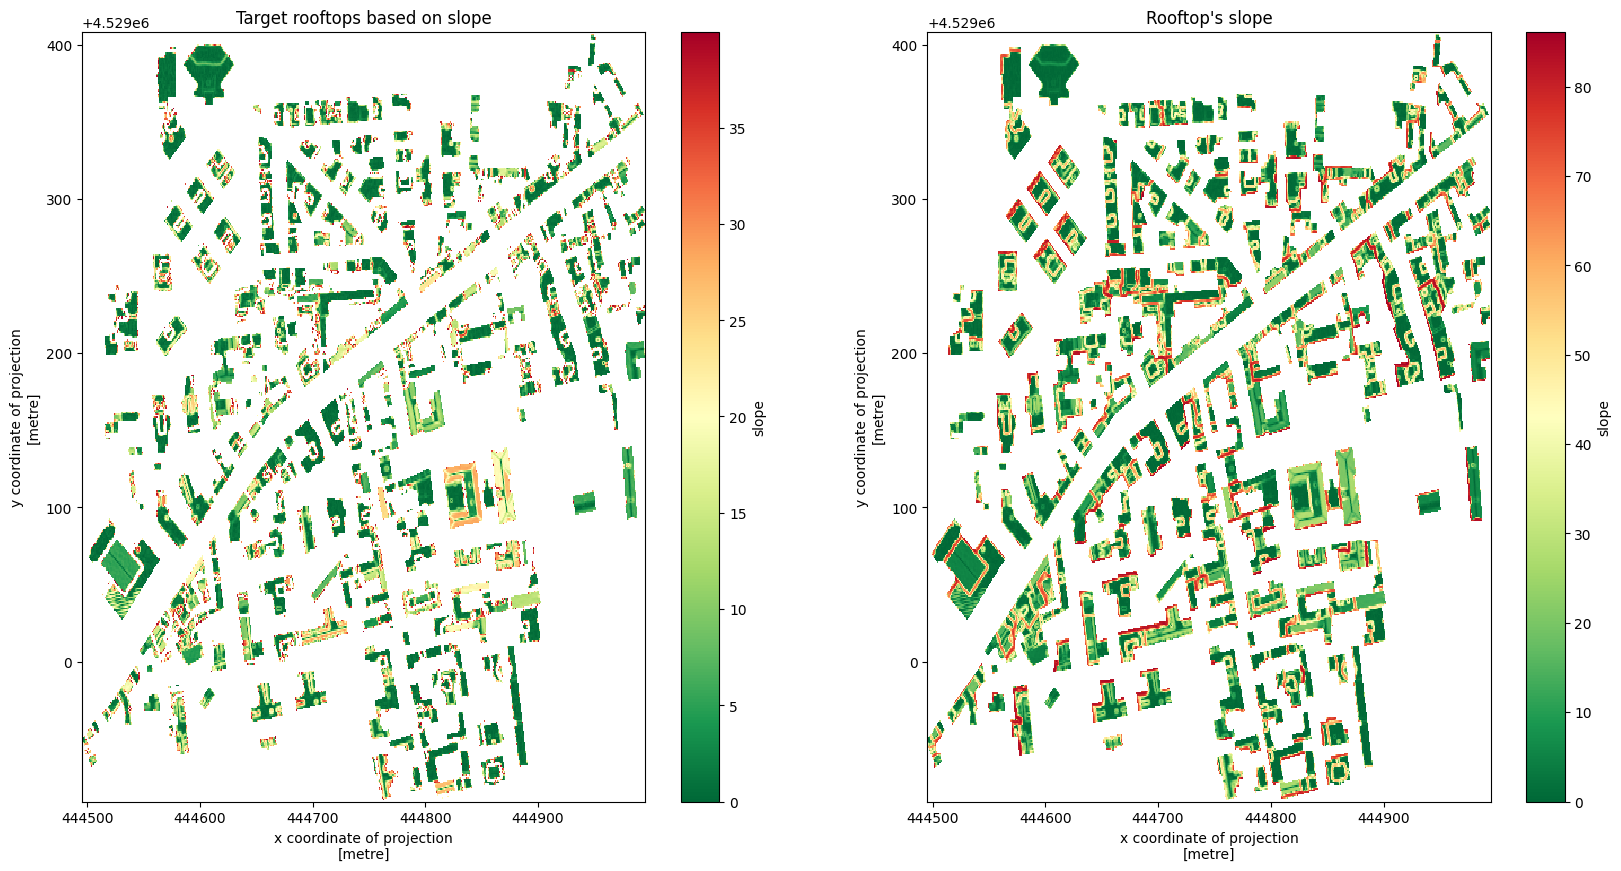

In [15]:
target_slope_rooftop = rooftop_slope.where(rooftop_slope <= 40)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
colormap = plt.cm.get_cmap('RdYlGn')

target_slope_rooftop.plot.imshow(
    cmap=colormap.reversed(),
    ax=axs[0],
)
axs[0].set_title("Target rooftops based on slope")

rooftop_slope.plot.imshow(
    cmap=colormap.reversed(),
    ax=axs[1]
)
axs[1].set_title("Rooftop's slope")

Text(0.5, 1.0, "Rooftop's aspect")

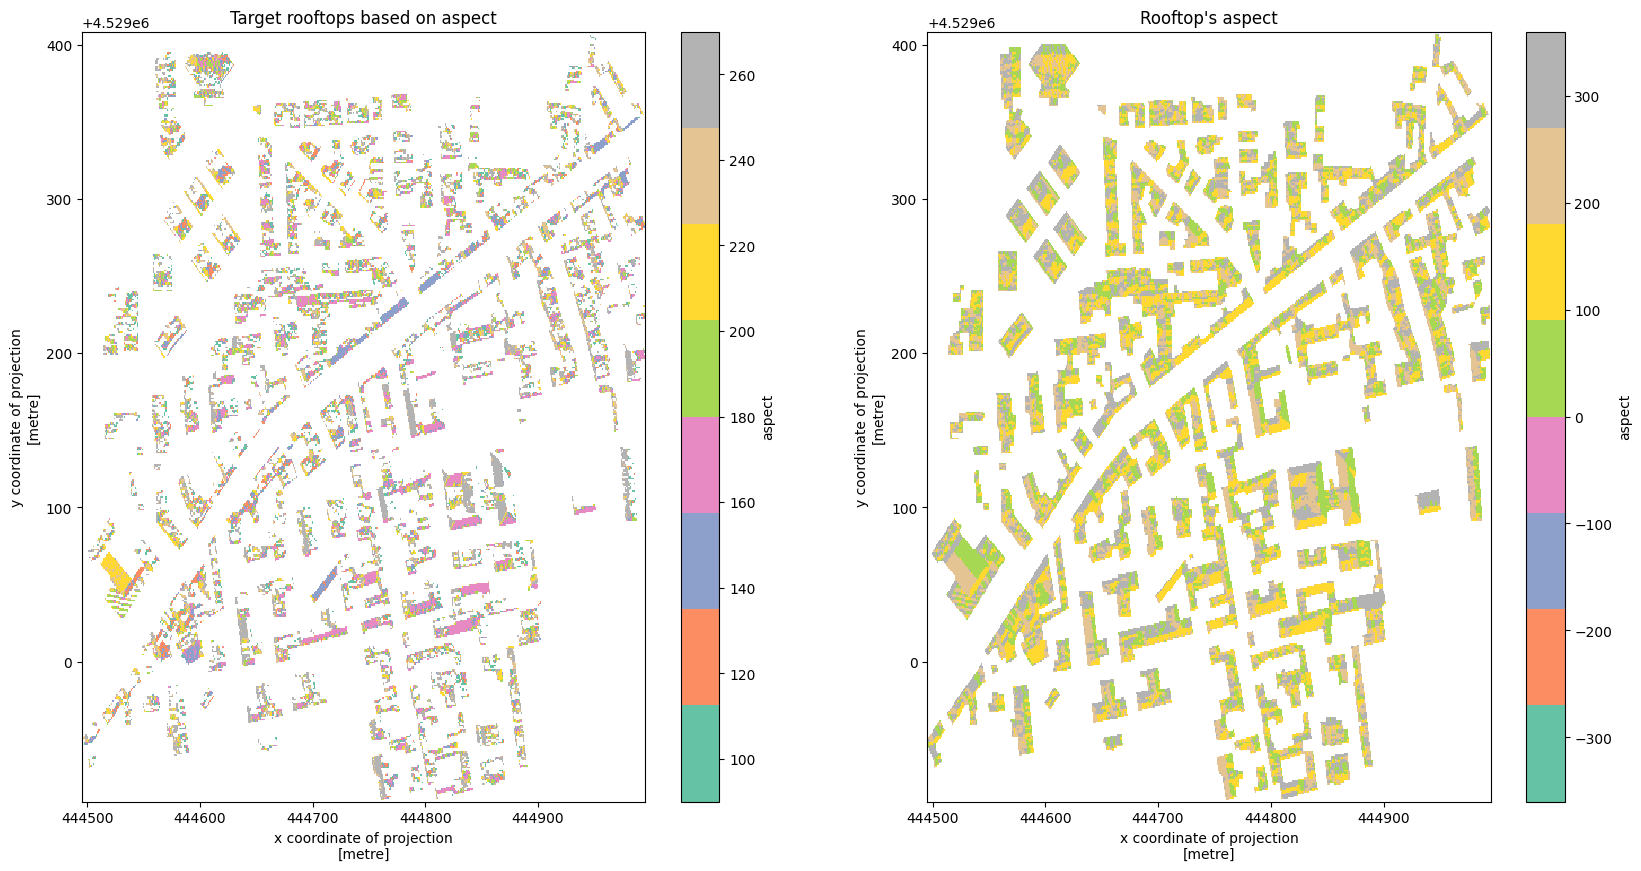

In [16]:
target_aspect_rooftop = rooftop_aspect.where((rooftop_aspect >= 90) & (rooftop_aspect <= 270))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

target_aspect_rooftop.plot.imshow(
    cmap='Set2',
    ax=axs[0]
)
axs[0].set_title("Target rooftops based on aspect")

rooftop_aspect.plot.imshow(
    cmap='Set2',
    ax=axs[1]
)
axs[1].set_title("Rooftop's aspect")

## 4.2 Individuazione dei tetti con pendenza ed esposizione ottimali

Text(0.5, 1.0, 'Target rooftops based on aspect')

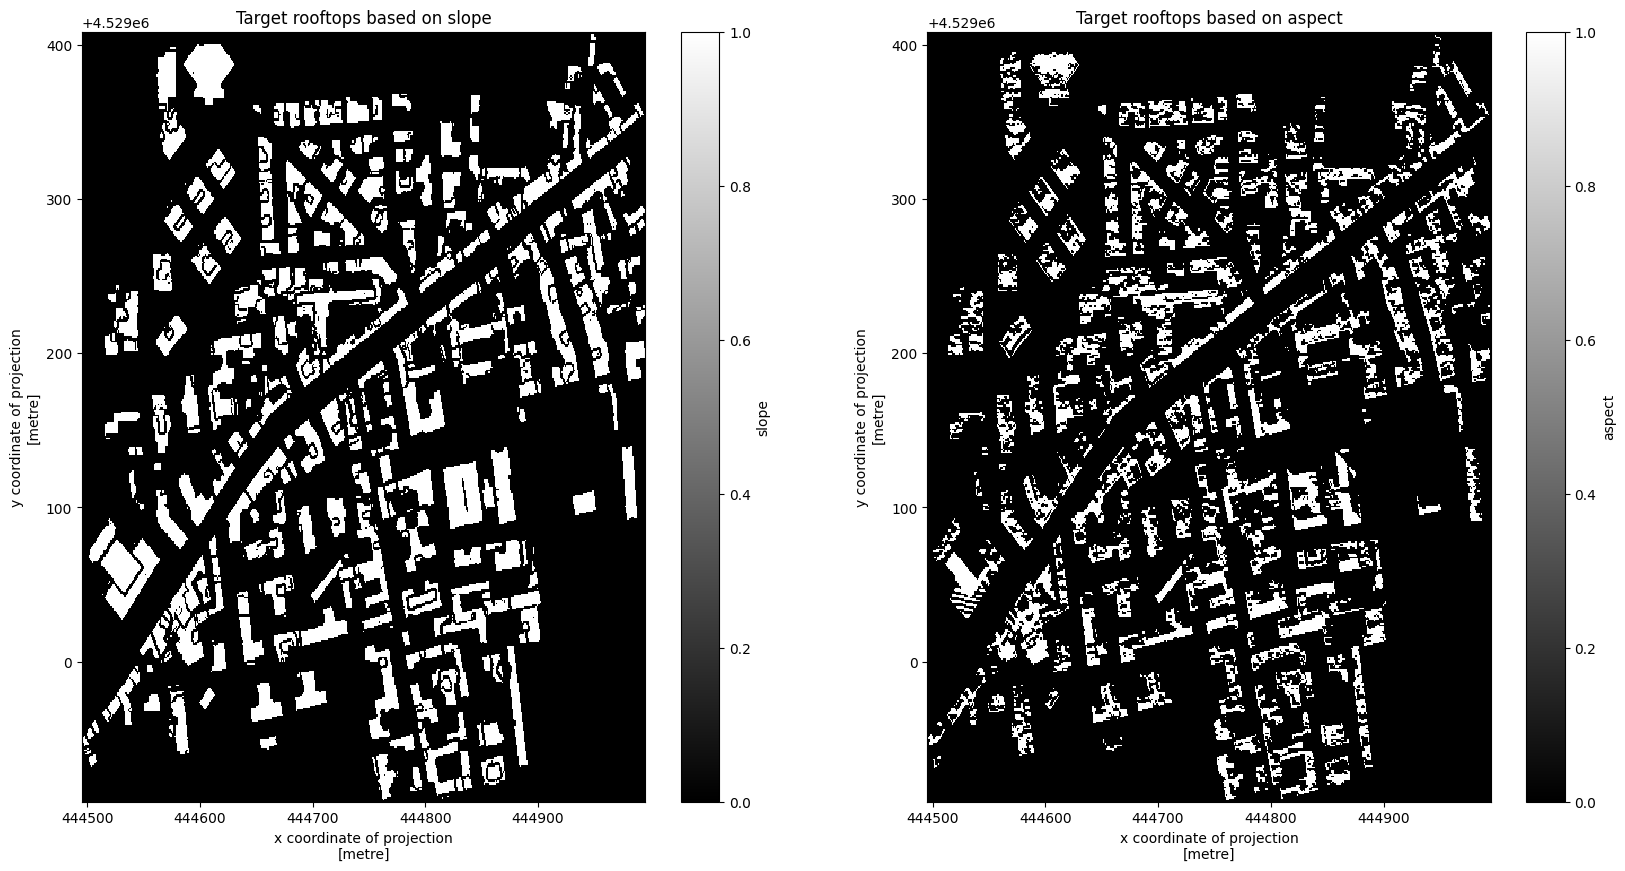

In [17]:
target_slope_rooftop_mask = ((target_slope_rooftop / target_slope_rooftop) >= 1).astype('uint8')
target_aspect_rooftop_mask = ((target_aspect_rooftop / target_aspect_rooftop) >= 1).astype('uint8')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

target_slope_rooftop_mask.plot.imshow(
    cmap="gray",
    ax=axs[0],

)
axs[0].set_title("Target rooftops based on slope")

target_aspect_rooftop_mask.plot.imshow(
    cmap="gray",
    ax=axs[1]
)
axs[1].set_title("Target rooftops based on aspect")

Text(0.5, 1.0, 'Target rooftops')

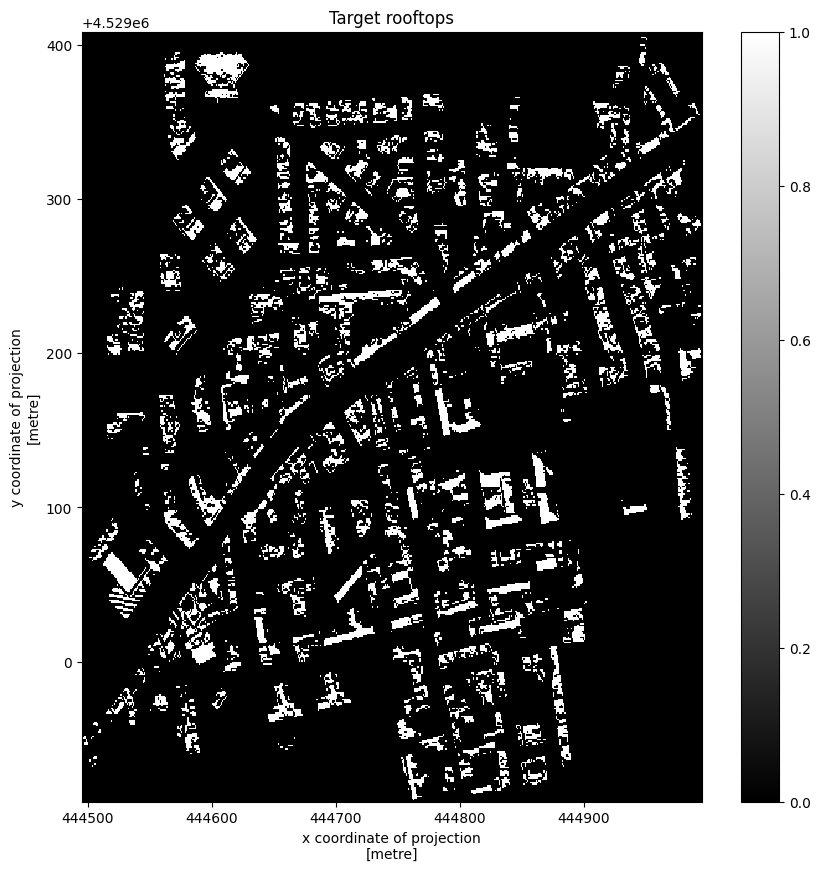

In [18]:
target_rooftop = target_slope_rooftop_mask * target_aspect_rooftop_mask

fig, ax = plt.subplots(figsize=(10, 10))

target_rooftop.plot.imshow(
    cmap='gray',
)
plt.title("Target rooftops")

## 4.3 Stima del potenziale produttivo

Ora che è chiaro quali sono i tetti potenzialmente utilizzabili è possibile calcolarne la produzione.

Il primo passo da seguire è convertire il `DataArray` creato in precedenza in un `DataFrame`.

In [19]:
target_rooftop_df = target_rooftop.to_dataframe(name="value").reset_index()
target_rooftop_df = target_rooftop_df[target_rooftop_df['value'] == 1]
target_rooftop_df = target_rooftop_df[['x', 'y', 'value']]
target_rooftop_df

,x,y,value
1951,444946.808,4529404.911,1
1952,444947.808,4529404.911,1
1953,444948.808,4529404.911,1
1954,444949.808,4529404.911,1
2455,444950.808,4529403.911,1
...,...,...,...
248266,444761.808,4528911.911,1
248267,444762.808,4528911.911,1
248268,444763.808,4528911.911,1
248269,444764.808,4528911.911,1


In questo modo si è ottenuto un oggetto che contiene i centroidi dei pixel del raster precedente, con i soli valori di interesse. Il passo successivo è convertire in `GeoDataFrame` il dataset ottenuto in precedenza.

In [20]:
gdf_point = gpd.GeoDataFrame(
    target_rooftop_df.value,
    geometry=gpd.points_from_xy(target_rooftop_df.x,target_rooftop_df.y),
    crs=raster.rio.crs.to_string()
)
gdf_point

,value,geometry
1951,1,POINT (444946.808 4529404.911)
1952,1,POINT (444947.808 4529404.911)
1953,1,POINT (444948.808 4529404.911)
1954,1,POINT (444949.808 4529404.911)
2455,1,POINT (444950.808 4529403.911)
...,...,...
248266,1,POINT (444761.808 4528911.911)
248267,1,POINT (444762.808 4528911.911)
248268,1,POINT (444763.808 4528911.911)
248269,1,POINT (444764.808 4528911.911)


Si è ottenuto un GeoDataFrame di punti, ma a me interessano i poligoni, quindi creo un buffer intorno ai punti in modo da riprodurre i pixel del raster con cui ho iniziato l'analisi. Quindi devo andare ad individuare la risoluzione del mio raster di partenza:

In [21]:
x, y = raster.rio.resolution()
print(f"Il raster di partenza ha una risoluzione di {x} x {y*-1} metri")

Il raster di partenza ha una risoluzione di 1.0 x 1.0 metri


Ora posso creare i miei poligoni.

In [22]:
gdf_polygon = gdf_point.buffer(distance=0.5, cap_style=3)
polygons = gdf_polygon.unary_union

gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polygons), crs=gdf_polygon.crs).explode(index_parts=True)
gdf.insert(loc=1, column="superficie_mq", value=gdf.geometry.area)
gdf

geometry  superficie_mq
0 0     POLYGON ((444503.308 4528932.411, 444503.308 4...            1.0
  1     POLYGON ((444505.308 4528934.411, 444506.308 4...            1.0
  2     POLYGON ((444501.308 4528936.411, 444501.308 4...            2.0
  3     POLYGON ((444504.308 4528937.411, 444504.308 4...            5.0
  4     POLYGON ((444500.308 4528947.411, 444500.308 4...            8.0
...                                                   ...            ...
  2284  POLYGON ((444989.308 4529288.411, 444989.308 4...            1.0
  2285  POLYGON ((444980.308 4529322.411, 444980.308 4...            1.0
  2286  POLYGON ((444980.308 4529325.411, 444981.308 4...            1.0
  2287  POLYGON ((444992.308 4529354.411, 444992.308 4...            1.0
  2288  POLYGON ((444985.308 4529360.411, 444984.308 4...           18.0

[2289 rows x 2 columns]

Ho ottenuto un GeoDataFrame con i dati di mio interesse. Quando scrissi l'articolo del [blog](https://massimilianomoraca.it/blog/gis/fotovoltaico-e-gis-come-individuare-lutilizzabilita-di-un-tetto/), oramai 6 annifa, 1 kwp occupava 7 metri quadri; non conosco i risvolti del mercato attuale ma ricordo che con la minuaturizzazione si andava verso la riduzione della superficie utile per produrre 1 kwp. Anche per questo articolo mi atterrò al dato del 2018 ma, prima di calcolare la produzione potenziale di energia dell'are in esame, andrò a filtrare tutto ciò che è inferiore a 7 metri quadri.

In [23]:
final_analysis = gdf[gdf.superficie_mq >= 7].reset_index()
final_analysis = final_analysis[['geometry', 'superficie_mq']]
final_analysis.insert(loc=2, column="potential_production_kw", value=final_analysis.superficie_mq*7)
final_analysis

,geometry,superficie_mq,potential_production_kw
0,"POLYGON ((444500.308 4528947.411, 444500.308 4...",8.0,56.0
1,"POLYGON ((444506.308 4528961.411, 444507.308 4...",8.0,56.0
2,"POLYGON ((444518.308 4528970.411, 444519.308 4...",35.0,245.0
3,"POLYGON ((444518.308 4528967.411, 444519.308 4...",9.0,63.0
4,"POLYGON ((444524.308 4529036.411, 444525.308 4...",24.0,168.0
...,...,...,...
641,"POLYGON ((444988.308 4529225.411, 444989.308 4...",12.0,84.0
642,"POLYGON ((444985.308 4529260.411, 444986.308 4...",16.0,112.0
643,"POLYGON ((444985.308 4529279.411, 444986.308 4...",9.0,63.0
644,"POLYGON ((444987.308 4529283.411, 444987.308 4...",22.0,154.0


Text(0.5, 1.0, 'Energy production map KWP')

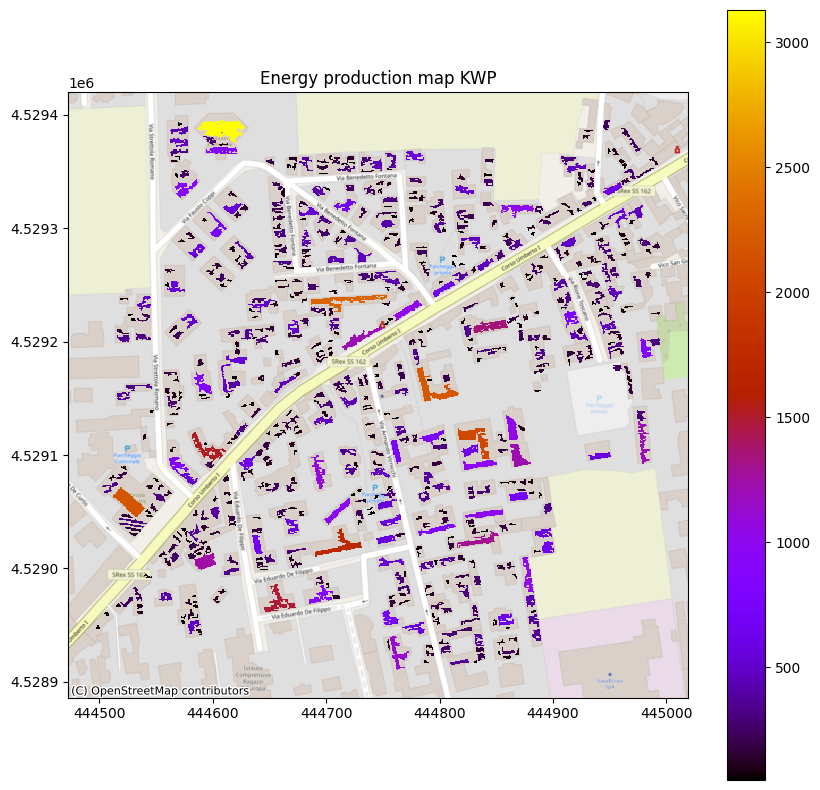

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

final_view = final_analysis.plot(column="potential_production_kw", cmap="gnuplot", ax=ax, legend=True)
cx.add_basemap(final_view, crs=final_analysis.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
final_view.set_title("Energy production map KWP")

# Conclusione

La stima del potenziale produttivo di un tetto è sicuramente un passo fondamentale per capire se il tetto in esame è da considerare per una analisi più approfondita o meno. Nel processo di analisi che ho esposto ho volutamente evitato di scendere troppo nel dettaglio di analisi proprio perchè:
1. avevo interesse ad esporre un flusso di analisi;
2. avevo interesse a stimare dei valori.

Ad esempio un aspetto su cui ho volutamente sorvolato è il calcolo delle superfici inclinate che mi avrebbe restituito un valore di produttività per tetto differente.

Hai commenti, indicazioni o soluzioni alternative in Python? Scrivi nella sezione [Discussioni](https://github.com/MaxDragonheart/PyGIS-Blog/discussions).

## Newsletter

Se vuoi ricevere aggiornamenti sui prossimi articoli [iscriviti alla newsletter](https://massimilianomoraca.it/newsletter/)!

## Telegram

Segui il canale Telegram **[CaffèGIS -  I GIS a supporto dei processi evolutivi territoriali](https://t.me/caffegis)** per ricevere aggiornamenti su iniziative ed informazioni a tema GIS.

## Offrimi una birra!

**Se trovi interessanti i miei articoli [offrimi una birra](https://www.paypal.com/paypalme/MassimilianoMoraca)!**

Alla prossima!